In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import tensorflow as tf

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from  tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import shutil
import time
#import torch
#import cv2 as cv2
#from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [3]:
c=0
for filename in os.listdir("../archive/images"):
    if filename.endswith(".jpg"):
        c+=1    
print(c)


10015


In [4]:
groundTruth = pd.read_csv('../archive/GroundTruth.csv')

In [5]:
groundTruth

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#Check to see if the categories are mutually exclusive
sumRows = groundTruth[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]].sum(axis=1) 
#Add up each row. If mutually exclusive sum of each row should be 1

print(sumRows.sum(axis=0))
print(len(sumRows))

10015.0
10015


In [7]:
sumColumns = pd.DataFrame(groundTruth[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]].sum(axis=0))
sumColumns = sumColumns.rename(columns={0: "Total"})
sumColumns['Percent Total'] = sumColumns['Total'] / len(groundTruth)

In [8]:
sumColumns
#Very skewed data. Will need to do stratified

,Total,Percent Total
MEL,1113.0,0.111133
NV,6705.0,0.669496
BCC,514.0,0.051323
AKIEC,327.0,0.032651
BKL,1099.0,0.109735
DF,115.0,0.011483
VASC,142.0,0.014179


In [9]:
#trainingDf, testingDf= train_test_split(groundTruth, test_size=0.30, random_state=42, stratify = groundTruth[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]])
#Stratify on each outcome

#modified
trainingDf, testingDf = train_test_split( groundTruth, test_size=0.30, random_state=42, stratify = groundTruth[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]])
#Stratify on each outcome





In [10]:
# Double check to see if stratification worked on the train set
trainSumColumns = pd.DataFrame(trainingDf[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]].sum(axis=0))
trainSumColumns = trainSumColumns.rename(columns={0: "Total"})
trainSumColumns['Percent Total'] = trainSumColumns['Total'] / len(trainingDf)
trainSumColumns

,Total,Percent Total
MEL,779.0,0.111127
NV,4693.0,0.669472
BCC,360.0,0.051355
AKIEC,229.0,0.032668
BKL,769.0,0.109700
DF,81.0,0.011555
VASC,99.0,0.014123


In [11]:
# Double check to see if stratification worked on the test set
testSumColumns = pd.DataFrame(testingDf[["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]].sum(axis=0))
testSumColumns = testSumColumns.rename(columns={0: "Total"})
testSumColumns['Percent Total'] = testSumColumns['Total'] / len(testingDf)
testSumColumns

,Total,Percent Total
MEL,334.0,0.111148
NV,2012.0,0.669551
BCC,154.0,0.051248
AKIEC,98.0,0.032612
BKL,330.0,0.109817
DF,34.0,0.011314
VASC,43.0,0.014309


In [12]:
#Just a simple test data set for setting up the models
train = trainingDf.iloc[1:15,:]

test = testingDf.iloc[1:10,:]

In [13]:
# Make a list to store all of the processed images
x_data_train = []


#Process all the images in the training data set.
for i in train.iloc[:,0]: #FIXME CHANGE BACK TO TRAINING DF
    path="../archive/images/" + i + ".jpg"
    
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)

    x_data_train.append(input_arr)
    




In [14]:
x_data_test = []

for i in test.iloc[:,0]: #FIXME CHANGE BACK TO TESTING DF
    path="../archive/images/" + i + ".jpg"
    
    image=tf.keras.preprocessing.image.load_img(
        path, grayscale=False, color_mode="rgb", target_size=None, interpolation="nearest")
    input_arr = tf.keras.preprocessing.image.img_to_array(image)

    x_data_test.append(input_arr)

In [16]:
x_data_train[0].shape


(450, 600, 3)

In [17]:
#Start Building model

shape = x_data_train[0].shape

In [18]:
# Simple dummy model
def buildModel():
    model = keras.models.Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu", input_shape=shape))
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(7, activation="softmax"))
    return model
    


In [19]:
m = buildModel()
m.summary()

2022-04-19 15:54:16.559984: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 446, 596, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 442, 592, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 221, 296, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 221, 296, 32)      0         
                                                                 
 flatten (Flatten)           (None, 2093312)           0         
                                                                 
 dense (Dense)               (None, 256)               535888128 
                                                        

In [20]:
m.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [21]:


#Get y-Data ready for model
y_train_final = np.asarray(train.loc[:, test.columns != 'image'])
# y_train_final = np.asarray(trainingDf.loc[:, test.columns != 'image'])
print(y_train_final.shape)


#Get x_Data ready for model
x_data_final = np.asarray(x_data_train)
print(x_data_final.shape) #x_train

#I think that this scales the data
x_data_final = x_data_final.astype('float32')
x_data_final = x_data_final / 255.



(14, 7)
(14, 450, 600, 3)


In [24]:
y_train_final

array([[0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [23]:
epochs = 10
history = m.fit(x_data_final, y_train_final, epochs=epochs, batch_size=64)

#look for keras tunner

Epoch 1/10
1/1 [==============================] - 31s 31s/step - loss: 338.1277 - accuracy: 0.4286
Epoch 2/10
1/1 [==============================] - 17s 17s/step - loss: 230.1093 - accuracy: 0.2143
Epoch 3/10
1/1 [==============================] - 25s 25s/step - loss: 78.4143 - accuracy: 0.2143
Epoch 4/10
1/1 [==============================] - 24s 24s/step - loss: 20.3855 - accuracy: 0.2143
Epoch 5/10
1/1 [==============================] - 26s 26s/step - loss: 3.4584 - accuracy: 0.5714
Epoch 6/10
1/1 [==============================] - 25s 25s/step - loss: 2.2382 - accuracy: 0.2857
Epoch 7/10
1/1 [==============================] - 27s 27s/step - loss: 2.7178 - accuracy: 0.1429
Epoch 8/10
1/1 [==============================] - 26s 26s/step - loss: 4.0500 - accuracy: 0.4286
Epoch 9/10
1/1 [==============================] - 26s 26s/step - loss: 4.0097 - accuracy: 0.2143
Epoch 10/10
1/1 [==============================] - 25s 25s/step - loss: 1.9207 - accuracy: 0.3571


### Autoencoder


In [9]:
#Process train data
x_data_final_train = np.asarray(x_data_train)
x_train = x_data_final_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

In [10]:
#Process test data
x_data_final_test = np.asarray(x_data_test)
x_test = x_data_final_test.astype('float32') / 255.
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [11]:
x_test.shape

(9, 810000)

In [23]:
encoding_dim = 64  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(810000,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(810000, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [24]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [25]:
#This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))

# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))


In [26]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [27]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose = False,
                validation_data=(x_test, x_test))

In [28]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


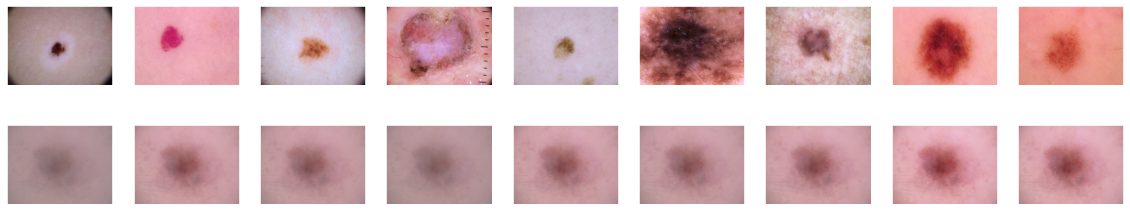

In [29]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 9  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(450, 600,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(450, 600,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Autoencoder for denoising.

In [19]:
x_train_new = x_data_final_train.astype('float32') / 255.
x_test_new = x_data_final_test.astype('float32') / 255.
x_train_new = np.reshape(x_train_new, (len(x_train), 450, 600, 3))
x_test_new = np.reshape(x_test_new, (len(x_test), 450, 600, 3))

noise_factor = 0.5
x_train_noisy = x_train_new + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_new.shape) 
x_test_noisy = x_test_new + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_new.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [20]:
x_train_noisy.shape

(14, 450, 600, 3)

In [21]:
x_train_new.shape

(14, 450, 600, 3)

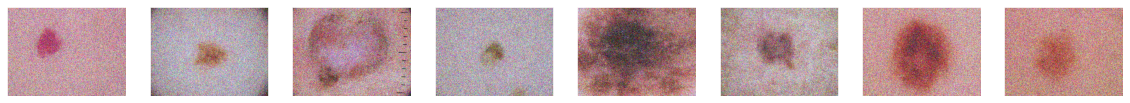

In [22]:
n = 8
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(450, 600, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [86]:
from tensorflow.keras import layers

input_img = keras.Input(shape=(450, 600, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [87]:
autoencoder.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 450, 600, 3)]     0         
                                                                 
 conv2d_55 (Conv2D)          (None, 450, 600, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 225, 300, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 225, 300, 32)      9248      
                                                                 
 conv2d_57 (Conv2D)          (None, 225, 300, 32)      9248      
                                                                 
 up_sampling2d_22 (UpSamplin  (None, 450, 600, 32)     0         
 g2D)                                                     

In [88]:
autoencoder.fit(x_train_noisy, x_train_new,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test_new))

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.7079 - val_loss: 0.6567
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 0.6626 - val_loss: 0.6302
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.6430 - val_loss: 0.6223
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.6398 - val_loss: 0.6197
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.6386 - val_loss: 0.6180
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.6358 - val_loss: 0.6191
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 0.6344 - val_loss: 0.6218
Epoch 8/10
1/1 [==============================] - 4s 4s/step - loss: 0.6349 - val_loss: 0.6227
Epoch 9/10
1/1 [==============================] - 5s 5s/step - loss: 0.6346 - val_loss: 0.6211
Epoch 10/10
1/1 [==============================] - 4s 4s/step - loss: 0.6330 - val_loss: 0.6189


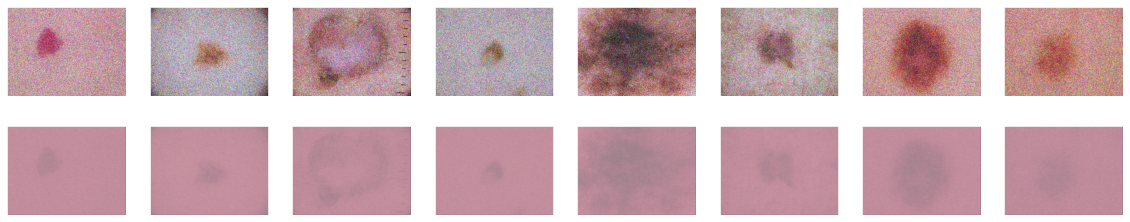

In [93]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 8
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(450, 600, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(450, 600, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()